<center>
 <font size="5"> <b>This notebook illustrates how to perform linear regression in R </b></font>
</center>

We consider a simple linear regression with one explanatory variables $x$ (straight line fit). The response variables are called $y$. The statistical model is:

$$y(x) = a x + b + \varepsilon$$

where $\varepsilon$ is the error. We assume that the error follows a normal distribution with mean $0$ and standard deviation $\sigma$:

$$\varepsilon \sim {\cal N}(0, \sigma)$$

The parameters to estimate are the slope $a$ and the intercept $b$.

The estimation is done by minimizing the sum of squared residuals 

$$\sum_{i=1} \left(y_i - y(x_i)\right)^2$$

where the $y_i$ are the measured values of $y$.

<!---$$x = \begin{pmatrix}x_1\\x_2\\x_3\\x_4\end{pmatrix} = \begin{pmatrix}1\\2\\3\\4\end{pmatrix}$$--->



'data.frame':	4 obs. of  2 variables:
 $ x: num  1 2 3 4
 $ y: num  2.5 4.5 6.54 8.42


(Intercept)           x 
  0.5353247   1.9821694

[1] "Printing model summary"



Call:
lm(formula = y ~ x, data = ds)

Residuals:
        1         2         3         4 
-0.018874 -0.002483  0.061588 -0.040231 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.53532    0.06581   8.135 0.014777 *  
x            1.98217    0.02403  82.491 0.000147 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05373 on 2 degrees of freedom
Multiple R-squared:  0.9997,	Adjusted R-squared:  0.9996 
F-statistic:  6805 on 1 and 2 DF,  p-value: 0.0001469


[1] "Printing model coeff (post-fit)"


(Intercept)           x 
  0.5353247   1.9821694

[1] "Printing fit rsquared"


[1] 0.9997062

[1] "Printing vcov"


,(Intercept),x
(Intercept),0.004330439,-0.0014434795
x,-0.001443480,0.0005773918


[1] "Printing analytical explicit calculations"


[1] "Analytical results: varslope=0.00057739 varintercept=0.00433044 covariance=-0.00144348"

[1] "Printing analytical matrix calculations"


,0.5353247
x,1.9821694


,,x
,0.004330439,-0.0014434795
x,-0.001443480,0.0005773918


[1] "Plotting"


ERROR: Error in summary(prd): object 'prd' not found


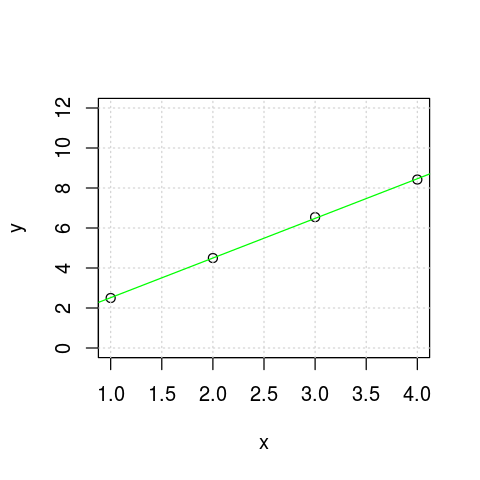

In [6]:
set.seed(1485)
options(repr.plot.width=4, repr.plot.height=4)
x <- c(1,2,3,4)
slopet <- 2
interceptt <- 0.4

# Generate pseudo-data
sigma <- 0.1
y <- slopet*x + interceptt + rnorm(length(x), 0, sigma)

# Making data frame
ds <- data.frame(x = x, y = y)
str(ds)

# Plot data
plot(y~x, ylim=c(0, 12))
grid()

# Make linear regression
ds.lm <- lm(y~x, data=ds)
coeffs = coefficients(ds.lm)
coeffs

print("Printing model summary")
summary(ds.lm)

print("Printing model coeff (post-fit)")
ds.lm$coef

print("Printing fit rsquared")
summary(ds.lm)$r.squared

print("Printing vcov")
vcov(ds.lm)


print("Printing analytical explicit calculations")
# Analytical covariance matrix (see my statistics exercices)
sigmahatsq <- 1/(length(x)-2)*sum((y - (coeffs[2]*x + coeffs[1]))^2)
factor <- sigmahatsq/(length(x)*sum(x^2) - (sum(x)*sum(x)))
varslope <- length(x)*factor
varintercept <- sum(x^2)*factor
covsllint <- -1*sum(x)*factor
sprintf("Analytical results: varslope=%.8f varintercept=%.8f covariance=%.8f", varslope, varintercept, covsllint)

print("Printing analytical matrix calculations")
# Analytical from matrices
X <- cbind(1, x)
betaHat <- solve(t(X) %*% X) %*% t(X) %*% y
#var_betaHat <- anova(mod)[[3]][2] * solve(t(X) %*% X)
covMatrix <- sigmahatsq * solve(t(X) %*% X)

betaHat
covMatrix


print("Plotting")
# Plot fit
# method 1
#yt <- coeffs[2]*x+coeffs[1]
#lines(x, yt, col="red")
# method 2
abline(ds.lm, col="green")

newx <- c(3)
prd1<-predict(ds.lm, newdata = data.frame(x=newx))
summary(prd)

prd2<-predict(ds.lm,interval = c("confidence"), level = 0.90,type="response")
prd2
lines(x,prd2[,2],col="red",lty=2)
lines(x,prd2[,3],col="red",lty=2)


# Analytical (in order to check that numerical computation finds analytical solution)
n <- length(x)
covariance <- cov(x, y)*n/(n-1)
sdx <- sd(x)*sqrt(n/(n-1))
sdy <- sd(y)*sqrt(n/(n-1))
corr <- covariance/(sdx*sdy)
slopeana <- corr*sdy/sdx
interceptana <- mean(y) - corr*sdy/sdx*mean(x)
slopeana
interceptana

# Use R's plot function of model
#par(mfrow = c(2,2))
#options(repr.plot.width=10, repr.plot.height=6)
#plot(ds.lm)